In [244]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pyqg_subgrid_experiments as pse
import pyqg
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
import importlib
importlib.reload(pse.dataset)
importlib.reload(pse)

<module 'pyqg_subgrid_experiments' from '/home/asr9645/pyqg_experiments/pyqg_subgrid_experiments/__init__.py'>

In [109]:
np.hstack((1,2))

array([1, 2])

In [97]:
rs = RunningStats()
rs.update_transform(np.arange(5))

array([-3.76060309, -1.88030155,  0.        ,  1.88030155,  3.76060309])

In [95]:
rs.inverse_transform(rs.transform(np.arange(5)))

array([0., 1., 2., 3., 4.])

In [79]:
train = pse.Dataset('../pyqg_subgrid_experiments/tests/fixtures/train.nc')
train['a'] = train.u**2 + train.v**2 - 2*train.u*train.v + 0.1*train.curl('u','v')

ds=train

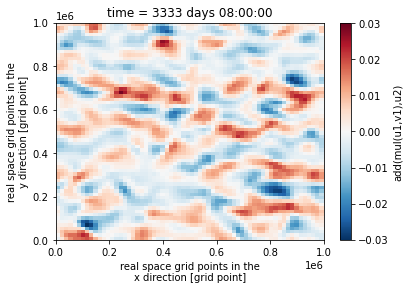

In [289]:
ds.extract_feature('add(mul(u1,v1),u2)').isel(run=0,time=-1).plot()

In [311]:
inputs = ['u','v','mul(u,u)','mul(v,v)','mul(u,v)','curl(u,v)','div(u,q)',
          'add(mul(u,u),mul(v,v))']
target = 'a'
    
def extract_x(ds):
    return np.array(np.stack([ds.extract_feature(f).data.ravel() for f in inputs], axis=1))
def extract_y(ds):
    return np.array(ds.extract_feature(target).data.ravel())

X = extract_x(ds)
scale = StandardScaler()
X2 = scale.fit_transform(X)
lr = LinearRegression()#asso(alpha=1e-5)
lr.fit(X, extract_y(ds))

LinearRegression()

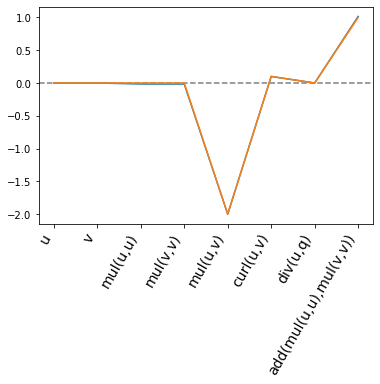

In [313]:
plt.plot(lr.coef_)
plt.axhline(0,ls='--',color='gray')
plt.plot([0,0,0,0,-2,0.1,0,1])
plt.xticks(np.arange(len(lr.coef_)), inputs, rotation=60, fontsize=14, ha='right')
plt.show()

In [96]:
class RunningStats:
    """Computes running mean and standard deviation
    Adapted from:
        *
        <http://stackoverflow.com/questions/1174984/how-to-efficiently-\
calculate-a-running-standard-deviation>
        * <http://mathcentral.uregina.ca/QQ/database/QQ.09.02/carlos1.html>
    """

    def __init__(self):
        self.n = 0.

    def update(self, x):
        self.n += len(x)
        if self.n <= len(x):
            self.m = x.mean(axis=0)
            self.s = x.std(axis=0) + 1e-16
        else:
            for xx in x:
                prev_m = self.m.copy()
                self.m += (xx - self.m) / self.n
                self.s += (xx - prev_m) * (xx - self.m)

    @property
    def mean(self):
        return self.m

    @property
    def variance(self):
        return self.s / self.n

    @property
    def std(self):
        return np.sqrt(self.variance)
    
    def remove_feature(self, i):
        self.m = np.hstack((self.m[:i], self.m[i+1:]))
        self.s = np.hstack((self.s[:i], self.s[i+1:]))
        
    def transform(self, x):
        return (x - self.mean) / self.std
    
    def inverse_transform(self, z):
        return  z * self.std + self.mean
    
    def update_transform(self, x):
        self.update(x)
        return self.transform(x)

In [277]:
class BatchSymbolicRegression(nn.Module):
    def __init__(self, features, target):
        super().__init__()
        self.features = features
        self.target = target
        self.removed_features = []
        self.initialize_weights()
        
    def initialize_weights(self):
        self.weights = nn.Parameter(torch.zeros(len(self.features)))
        self.bias = nn.Parameter(torch.zeros(1)[0])
        
    def forward(self, x):
        return (self.weights * x).sum(dim=1) + self.bias
    
    def as_tensor(self, x):
        return torch.tensor(x.astype(np.float32))
    
    def extract_x(self, ds):
        return np.array(np.stack([
            ds.extract_feature(f).data.ravel() for f in self.features
        ], axis=1))
    
    def extract_y(self, ds):
        return np.array(
            ds.extract_feature(self.target).data.ravel()
        )
    
    def add_feature(self, feat):
        pass
    
    def remove_feature(self, feat):
        assert feat in self.features
        i = self.features.index(feat)
        self.weights = nn.Parameter(torch.cat((
            self.weights[:i],
            self.weights[i+1:]
        )))
        self.features = self.features[:i] + self.features[i+1:]
        self.x_stats.remove_feature(i)
        self.removed_features.append(feat)
        
    @property
    def normalized_weights(self):
        return self.weights * self.as_tensor(self.y_stats.std / self.x_stats.std)
    
    def fit(self, ds, learning_rate=0.01, num_steps=2000, threshold_every=200, decay_lr=0.1, l1_weights=0.001, l2_weights=0.0):
        """
        Repeatedly:
          - Take t steps of SGD (w/ L1 & L2 penalties)
          - Remove all features with weights below a threshold
          - Also be learning the scales of each feature
          
        Potentially:
          - Add more features by combining existing features if performance has not yet achieved a given threshold
        """
        self.x_stats = RunningStats()
        self.y_stats = RunningStats()
        
        if 'run' not in ds.dims: ds = ds.expand_dims('run')
        if 'time' not in ds.dims: ds = ds.expand_dims('time')
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        runtimes = [(r,t) for r in range(len(ds.run)) for t in range(len(ds.time))]
        step = 0
        thresh_loss = 0.0
        thresh_steps = 0
        while step < num_steps:
            np.random.shuffle(runtimes)
            for r, t in runtimes:
                batch = ds.isel(run=r, time=t)
                x = self.x_stats.update_transform(self.extract_x(batch))
                y = self.y_stats.update_transform(self.extract_y(batch))
                
                y_scale = self.as_tensor(np.array(self.y_stats.std))
                
                optimizer.zero_grad()
                yhat = self.forward(self.as_tensor(x))
                loss = (
                    criterion(yhat, self.as_tensor(y))
                    + l1_weights * torch.norm(self.normalized_weights, 1)
                    + l2_weights * torch.norm(self.normalized_weights, 2)
                )
                loss.backward()
                optimizer.step()
                step += 1
                thresh_loss += loss.item()
                thresh_steps += 1
                if step % 25 == 0:
                    print(loss.item())
                
                if step and step % threshold_every == 0:
                    for i in range(len(self.weights)):
                        print(f"{self.normalized_weights[i].data.numpy():.2e}: {self.features[i]}")
                    w = self.normalized_weights
                    

                    to_remove = [feat for i, feat in enumerate(self.features)
                                      if abs(w[i]) < learning_rate]
                    
                    to_remove = []
                    for feat in to_remove:
                        self.remove_feature(feat)    
                    learning_rate *= decay_lr
                    optimizer = optim.SGD(self.parameters(), lr=learning_rate)
                    #print("Removed:", to_remove)
                    #print(f"Loss after thresholding: {thresh_loss/thresh_steps}")
                    thresh_loss = 0
                    thresh_steps = 0

In [278]:
sr = BatchSymbolicRegression(
  inputs,
    target
)

In [281]:
sr.fit(train, learning_rate=0.1)

2.849177122116089
2.360546112060547
2.076648235321045
2.737417221069336
1.8187146186828613
2.909109354019165
2.47998309135437
2.7874937057495117
7.46e-07: u
1.99e-06: v
-8.41e-02: mul(u,u)
-8.44e-02: mul(v,v)
-2.00e+00: mul(u,v)
-1.45e+02: curl(u,v)
1.07e+03: div(u,q)
1.09e+00: add(mul(u,u),mul(v,v))
0.20890766382217407
0.15483297407627106
0.2021801620721817
0.16799688339233398
0.18857033550739288
0.17846417427062988
0.18746715784072876
0.1863824427127838
-1.45e-06: u
-5.99e-07: v
-7.86e-02: mul(u,u)
-7.93e-02: mul(v,v)
-1.99e+00: mul(u,v)
1.79e+01: curl(u,v)
-1.57e+02: div(u,q)
1.08e+00: add(mul(u,u),mul(v,v))
0.03596598654985428
0.006416706368327141
0.034524623304605484
0.00787271186709404
0.03315940499305725
0.009151634760200977
0.032041996717453
0.010303198359906673
-2.76e-07: u
-1.59e-09: v
-7.82e-02: mul(u,u)
-7.88e-02: mul(v,v)
-1.99e+00: mul(u,v)
2.50e+00: curl(u,v)
-2.56e+01: div(u,q)
1.08e+00: add(mul(u,u),mul(v,v))
0.003936810418963432
0.006042388267815113
0.0039548389613628

KeyboardInterrupt: 

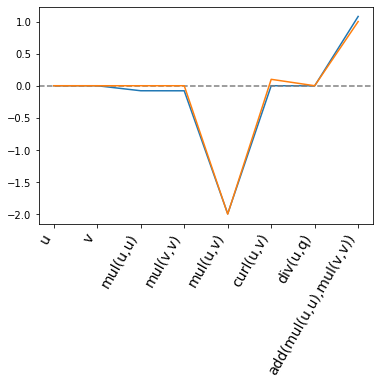

In [282]:
plt.plot(sr.normalized_weights.data.numpy())
plt.axhline(0,ls='--',color='gray')
plt.plot([0,0,0,0,-2,0.1,0,1])
plt.xticks(np.arange(len(lr.coef_)), inputs, rotation=60, fontsize=14, ha='right')
plt.show()

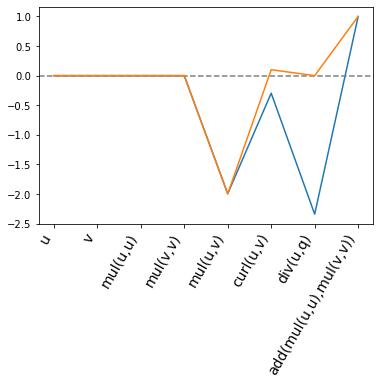

In [276]:
plt.plot(sr.normalized_weights.data.numpy())
plt.axhline(0,ls='--',color='gray')
plt.plot([0,0,0,0,-2,0.1,0,1])
plt.xticks(np.arange(len(lr.coef_)), inputs, rotation=60, fontsize=14, ha='right')
plt.show()